In [1]:
import os
import time
import logging
from datetime import datetime
from collections import defaultdict

import numpy as np

import torch

from evaluate.evaluate import evaluate, evaluate_classic, evaluate_prediction

#from .model.model import load_VCI

from dataset.dataset import load_dataset_splits, load_dataset_train_test

from utils.general_utils import initialize_logger, ljson
from utils.data_utils import data_collate

In [2]:
from dataset.dataset import load_dataset_splits, load_dataset_train_test

In [3]:
# Load arguments
modelpath = "/cluster/home/rquiles/fcr/tahoe_test/model/saves/test_run_2025.09.29_16:51:53/model_seed=None_epoch=930.pt"
state_dict = torch.load(modelpath)
args = state_dict[1]

args["embed_outcomes"] = True
args["embed_treatments"] = False
args["embed_covariates"] = True

## Load the model and datasets 

In [4]:
from train.train import prepare
trained_model, datasets = prepare(args, state_dict[0], "all")

Performing automatic train-test split with 0.2 ratio.


## Load Representations

In [5]:
import numpy as np
#import importlib
#import model
#importlib.reload(model)

ZXs = []
ZTs = []
ZXTs = []
index = 1
for data in datasets["loader_tr"]:
    print(index, end=" ")
    (genes, perts, cf_genes, cf_perts, covariates) = (
            data[0], data[1], data[2], data[3], data[4:])

    ZX, ZXT, ZT = trained_model.get_latent_presentation(genes, perts, covariates, sample=False) # sigma1=2e-1, sigma2=5e-3, sigma3=1e-3)
    ZXs.extend(ZX)
    ZTs.extend(ZT)
    ZXTs.extend(ZXT)
    index += 1


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 

In [6]:
ZXs = [e.detach().cpu().numpy() for e in ZXs]
ZXs = np.array(ZXs)

ZXTs = [e.detach().cpu().numpy() for e in ZXTs]
ZXTs = np.array(ZXTs)

ZTs = [e.detach().cpu().numpy() for e in ZTs]
ZTs = np.array(ZTs)

In [7]:
ZXs.shape

(19433, 64)

## Load the RAW data to ADATA

In [8]:
import scanpy as sc
adata = sc.read(args["data_path"])


In [9]:
adata.obsm["ZXs"] = ZXs
adata.obsm["ZTs"] = ZTs
adata.obsm["ZXTs"] = ZXTs


## Plot the Zx

In [10]:
sc.pp.neighbors(adata, use_rep="ZXs")
sc.tl.umap(adata, min_dist=0.3)
adata.obs["covariates"] = adata.obs["covariates"].astype(str)
# adata.obs["cell_type"] = adata.obs["cell_type"].astype(str)
# adata.obs["dose"] = adata.obs["dose"].astype(str)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [11]:
# def combine_cov(row):
#     celltypes = row["cell_type"]
#     replicate = row["replicate"]
#     return celltypes+'_'+replicate

# adata.obs["covariate"] = adata.obs.apply(combine_cov, axis=1)

In [12]:
sc.set_figure_params(dpi=80, dpi_save=600, format='png')

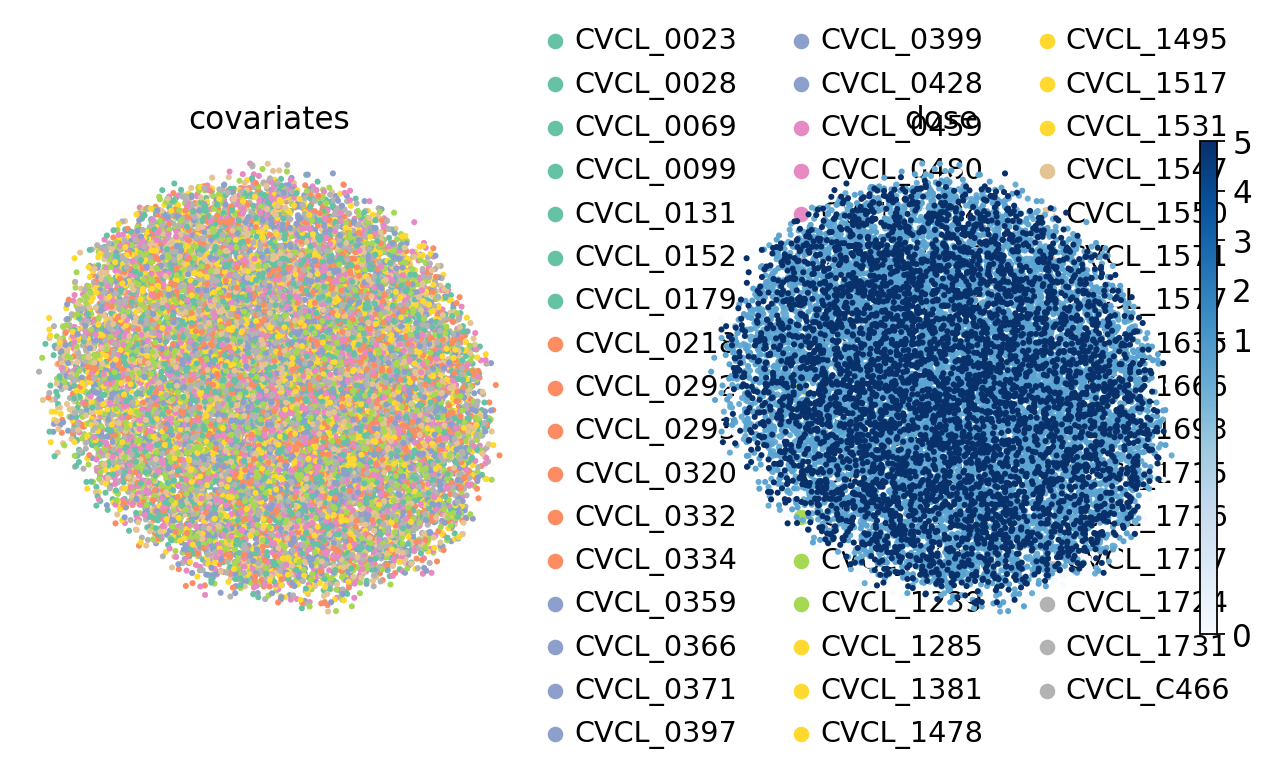

In [14]:
sc.pl.umap(
    adata,
    color=["covariates", "dose"],
    frameon=False,
    palette = "Set2",
    size = 30,
    outline_color= "gray",
    outline_width = 30,
    color_map = 'Blues',
    vcenter=0.01,

)

## Plot The Ztx

In [15]:
sc.pp.neighbors(adata, use_rep="ZXTs")
sc.tl.umap(adata,min_dist=0.5)

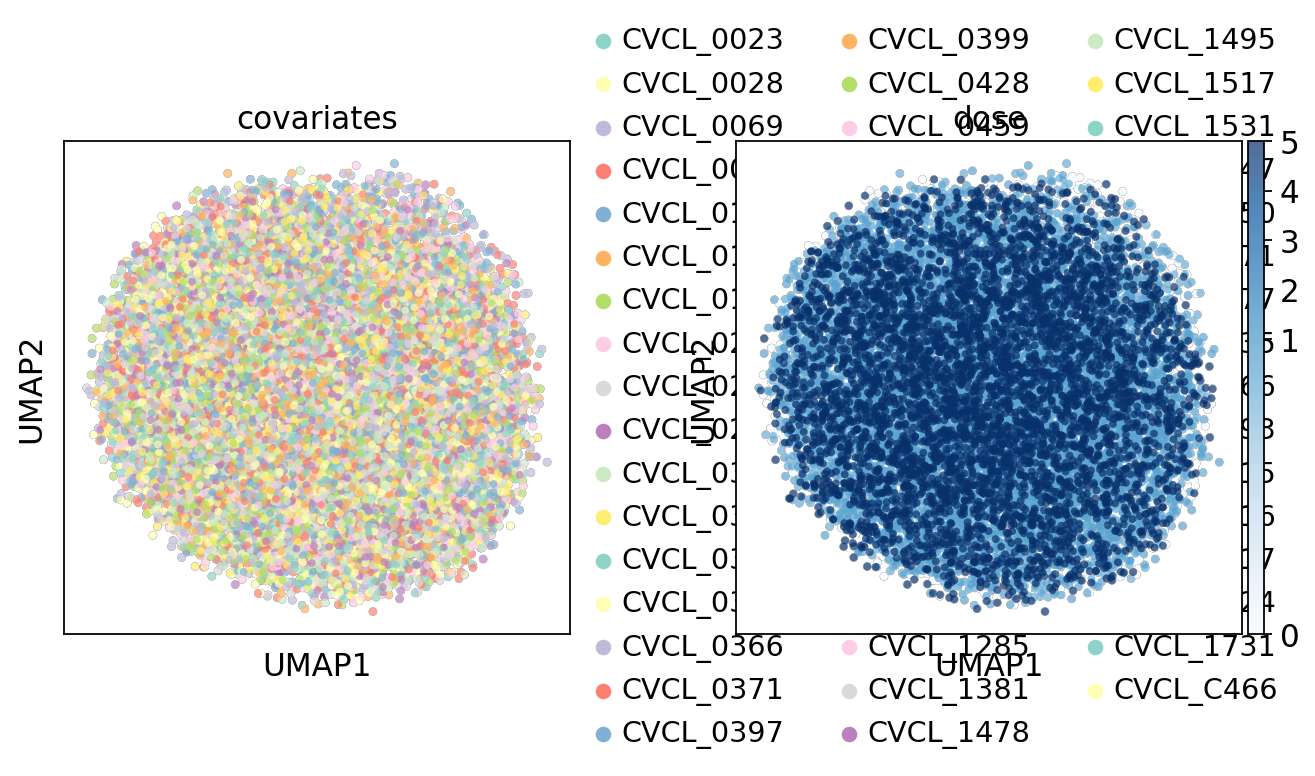

In [18]:
import seaborn as sns

umap_kwargs = dict(
    add_outline=True, outline_width=(0.05,0), outline_color=('grey', 'white'))
sc.pl.umap(
        adata,
        color=["covariates", "dose"],
        frameon=True,
        palette = sns.color_palette('Set3'),
        size = 50,
        color_map = 'Blues',
        vcenter=0.01,**umap_kwargs)


## Plot Zt

In [19]:
sc.pp.neighbors(adata, use_rep="ZTs")

In [20]:
sc.tl.umap(adata, min_dist=0.5)

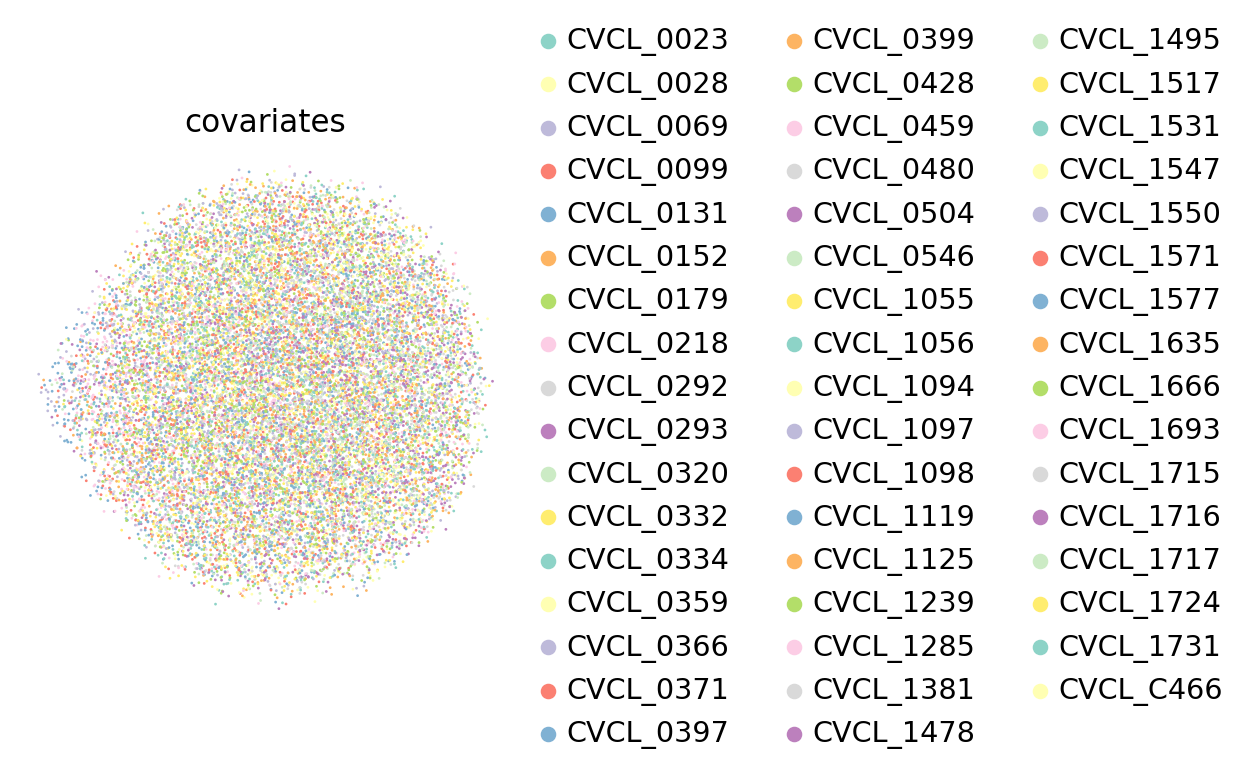

In [22]:
sc.pl.umap(
    adata,
    color=["covariates"],
    frameon=False)

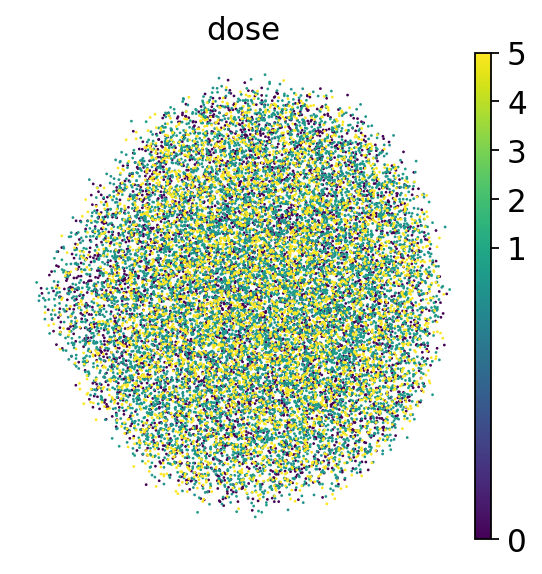

In [23]:
sc.pl.umap(
    adata,
    color=["dose"],
    vcenter=0.01,
    frameon=False)

## Evaluation Metrics

## Clustering Results

In [181]:
## Leiden clustering with latent representations
sc.pp.neighbors(adata, use_rep="ZXs")
sc.tl.leiden(adata)

In [112]:
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
from sklearn.metrics import adjusted_rand_score as ari

In [113]:
def change_cov_pert(row):
    cov_pert = row["cov_pert_name"].split("_")
    treatment = row["Agg_Treatment"]
    dose = row["dose"]
    cov_pert[-1] = treatment
    cov_pert.append(str(dose))
    return "_".join(cov_pert)

change_cov_pert(adata.obs.iloc[1])


'MCF7_rep2_HDAC_1.0'

In [114]:
adata.obs.cov_pert_name = adata.obs.apply(lambda row: change_cov_pert(row), axis=1)

## ZX clustering results

In [182]:
nmivalue = nmi(adata.obs.covariate.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)

0.8863428628937162


In [183]:
arivalue = ari(adata.obs.covariate.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.8238444574513598


In [184]:
nmivalue = nmi(adata.obs.dose.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)

0.09829543937340746


In [185]:
arivalue = ari(adata.obs.dose.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.05301747408077814


In [186]:
nmivalue = nmi(adata.obs.cov_pert_name.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)
arivalue = ari(adata.obs.cov_pert_name.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.6511332989518566
0.31726414919247337


## ZT clustering results

In [187]:
sc.pp.neighbors(adata, use_rep="ZTs")
sc.tl.leiden(adata)

In [188]:
nmivalue = nmi(adata.obs.covariate.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)
arivalue = ari(adata.obs.covariate.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.5619585830678413
0.1395229654570747


In [189]:
nmivalue = nmi(adata.obs.dose.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)
arivalue = ari(adata.obs.dose.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.27583042876320196
0.06860050247808464


In [190]:
nmivalue = nmi(adata.obs.cov_pert_name.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)
arivalue = ari(adata.obs.cov_pert_name.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.646582288990604
0.29361767026155716


## ZXT clustering results

In [191]:
sc.pp.neighbors(adata, use_rep="ZXTs")
sc.tl.leiden(adata)

In [192]:
nmivalue = nmi(adata.obs.covariate.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)
arivalue = ari(adata.obs.covariate.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.7923130132865274
0.5441595967472919


In [193]:
nmivalue = nmi(adata.obs.dose.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)
arivalue = ari(adata.obs.dose.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.2253500405576085
0.0880559105845019


In [194]:
nmivalue = nmi(adata.obs.cov_pert_name.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)
arivalue = ari(adata.obs.cov_pert_name.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.7177526301183345
0.3721521537956975
